In [3]:
!pip install wordcloud
import pandas as pd 
import string
import numpy as np
import re
from textblob import TextBlob
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
from nltk.classify import SklearnClassifier
from nltk import precision,recall
import itertools

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Read the files and put them in a pandas dataset.There are three different types: the train dataset(in order to train the classifier),the development set(in order to tune the hyperparameters of the desired algorithm),the test set(the set we will test the algorithm).

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [5]:
cols = ['id','sentiment','tweet']
tr_files=['/content/drive/My Drive/twitter/twitter-2013train-A.tsv','/content/drive/My Drive/twitter/twitter-2015train-A.tsv','/content/drive/My Drive/twitter/twitter-2016train-A.tsv']
dev_files_te='/content/drive/My Drive/twitter/twitter-2016dev-A.tsv'
dev_files_tr='/content/drive/My Drive/twitter/twitter-2016devtest-A.tsv'
te_files='/content/drive/My Drive/twitter/twitter-2016test-A.tsv'
list_=[]
for file_ in tr_files:
    df = pd.read_csv(file_,names=cols, header=None,sep='\t')
    list_.append(df)
df_train = pd.concat(list_)

df = pd.read_csv(te_files,names=cols, header=None,sep='\t')
df_test=df
    
df = pd.read_csv(dev_files_tr,names=cols, header=None,sep='\t')
df_dev_tr = df

df = pd.read_csv(dev_files_te,names=cols, header=None,sep='\t')
df_dev_te = df

print 'Total train tweets read ',len(df_train)
print 'Total test tweets read ',len(df_test)
print 'Total dev train tweets read ',len(df_dev_tr)
print 'Total dev test tweets read ',len(df_dev_te)

Total train tweets read  16045
Total test tweets read  20342
Total dev train tweets read  2000
Total dev test tweets read  489


Keep only the datasets that their tweets are available.Remove the ones that their tweet text says 'Not available'.

In [6]:
df_train=df_train[df_train.tweet!='Not Available']
df_test=df_test[df_test.tweet!='Not Available']
df_dev_te=df_dev_te[df_dev_te.tweet!='Not Available']
df_dev_tr =df_dev_tr[df_dev_tr.tweet!='Not Available']
print 'Sample of train data:',df_train.head()
print 'Sample of test data:',df_test.head()

Sample of train data:                    id  ...                                              tweet
0  264183816548130816  ...  Gas by my house hit $3.39!!!! I'm going to Cha...
3  264249301910310912  ...  Iranian general says Israel's Iron Dome can't ...
6  264105751826538497  ...  with J Davlar 11th. Main rivals are team Polan...
7  264094586689953794  ...  Talking about ACT's &amp;&amp; SAT's, deciding...
9  254941790757601280  ...  They may have a SuperBowl in Dallas, but Dalla...

[5 rows x 3 columns]
Sample of test data:                    id  ...                                              tweet
0  619950566786113536  ...  Picturehouse's, Pink Floyd's, 'Roger Waters: T...
1  619969366986235905  ...  Order Go Set a Watchman in store or through ou...
3  619974445185302528  ...  If you could ask an onstage interview question...
4  619987808317407232  ...  A portion of book sales from our Harper Lee/Go...
5  619994586182619136  ...  Excited to read "Go Set a Watchman" on Tuesday...

Print the number of sentimens (positive,negative,neutral) that exist in each dataset.

In [7]:
print 'Sentiments in train:',df_train.sentiment.value_counts()
print 'Sentiments in test:',df_test.sentiment.value_counts()
print 'Sentiments in dev train test:',df_dev_tr.sentiment.value_counts()
print 'Sentiments in dev test:',df_dev_te.sentiment.value_counts()

Sentiments in train: neutral     5143
positive    5117
negative    1658
Name: sentiment, dtype: int64
Sentiments in test: neutral     7727
positive    5439
negative    2271
Name: sentiment, dtype: int64
Sentiments in dev train test: positive    777
neutral     539
negative    246
Name: sentiment, dtype: int64
Sentiments in dev test: neutral     199
positive    116
negative     41
Name: sentiment, dtype: int64


Keep only the neccessary columns and drop id column.

In [0]:
d_tr=df_train[['tweet','sentiment']]
d_te=df_test[['tweet','sentiment']]
dev_tr=df_dev_tr[['tweet','sentiment']]
dev_te=df_dev_te[['tweet','sentiment']]

Remove tweets that their text has any useless (for sentiment analysis purposes) mentions to other users,html links,hashtag symbol from hashtags and RT (retweets).

In [0]:
stopwords_set = set(stopwords.words("english"))
def clean_text(dataset):
    tweets=[]
    for index, row in dataset.iterrows():
        words_filtered = [e.lower() for e in row.tweet.split() if len(e) >= 3]
        words_cleaned = [word.translate(None, string.punctuation) for word in words_filtered
            if 'http' not in word
            and not word.startswith('@')
            and not word.startswith('#')
            and word != 'RT'
            and word not in stopwords_set]
        words_without_stopwords = [word for word in words_cleaned if not word in stopwords_set]
        tweets.append((words_cleaned,row.sentiment))
    return tweets
        
train=clean_text(d_tr)
dev_tr=clean_text(dev_tr)
dev_te=clean_text(dev_te)
test=clean_text(d_te)

gas house hit 339 im going chapel hill sat


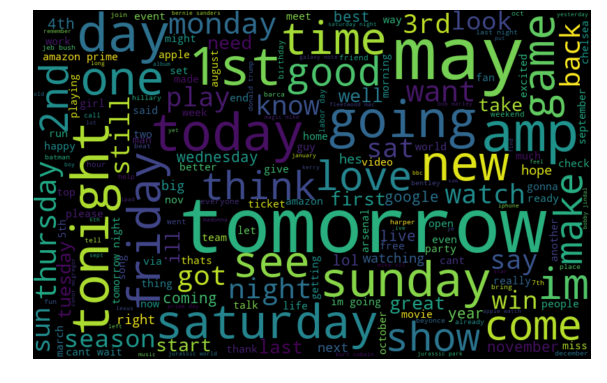

In [10]:
import matplotlib.pyplot as plt 
print(" ".join(train[0][0]))
all_words =" ".join([" ".join(text[0]) for text in train])
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

Train the classifier with the development set to find the best hyperparameters of the algorithm. Pipeline will execute the functions sequentially.We fit the dev train data to MultinomialNB classifier.The hyperparameters to tune the algorithm are :

ngram_range: The vocabulary of the algorithm will contain (1,1)->unigrams,(1,2)-> unigram and bigrams,(1,3)->unigrams,bigrams and trigrams.It is an argument pass to CountVectorizer function that converts a collection of texts to a matrix of token counts.

use_idf:If this is true,it uses the result of CountVectorizer into TfidfTransformer that transforms a count matrix to a normalized tf or tf-idf representation.Otherwise,this is skipped.

alpha:Additive (Laplace/Lidstone) smoothing parameter.

fit_prior: Whether to learn class prior probabilities or not. If false, a uniform prior will be used.


In [11]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.metrics import accuracy_score

text=[' '.join(x[0]) for x in dev_tr]
sent=[x[1] for x in dev_tr]
clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB()),
])
clf.fit(text,sent)
parameters = {'vect__ngram_range': [(1, 1), (1, 2),(1,3),(2,3),(2,4),(2,5),(3,4)],
              'tfidf__use_idf': (True, False),
              'clf__alpha': (1,0.1,0.01,0.001),
              'clf__fit_prior':(True,False),
}
gs_clf = GridSearchCV(clf, parameters, n_jobs=-1)
gs_clf = gs_clf.fit(text,sent)
print 'MultinomialNB has best score of ',gs_clf.best_score_,' and best parameters ',gs_clf.best_params_
test_text=[' '.join(x[0]) for x in dev_te]
target=[x[1] for x in dev_te]
result=clf.predict(test_text)

print(metrics.classification_report(target, result,['positive','negative','neutral']))
metrics.confusion_matrix(target,result)
print 'Accuracy ',accuracy_score(result,target)

/usr/local/lib/python2.7/dist-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


MultinomialNB has best score of  0.49167733674775926  and best parameters  {'vect__ngram_range': (3, 4), 'clf__fit_prior': True, 'tfidf__use_idf': True, 'clf__alpha': 1}
              precision    recall  f1-score   support

    positive       0.34      0.98      0.50       116
    negative       0.00      0.00      0.00        41
     neutral       0.69      0.06      0.10       199

   micro avg       0.35      0.35      0.35       356
   macro avg       0.34      0.35      0.20       356
weighted avg       0.49      0.35      0.22       356

Accuracy  0.351123595505618


/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Use the optimal parameters in order to fit the training data to the MultinomialNB and then apply the test set and measure the results.

In [12]:
clf=[]
if gs_clf.best_params_['tfidf__use_idf']==True:
    clf = Pipeline([('vect', CountVectorizer(gs_clf.best_params_['vect__ngram_range'])),
                     ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB(gs_clf.best_params_['clf__alpha'])),
])
else:
    clf = Pipeline([('vect', CountVectorizer(gs_clf.best_params_['vect__ngram_range'])),
                     ('clf', MultinomialNB(gs_clf.best_params_['clf__alpha'])),
])
text=[' '.join(x[0]) for x in train]
sent=[x[1] for x in train]

clf.fit(text,sent)
print 'Finished the fitting.'

Finished the fitting.


In [0]:
test_text=[' '.join(x[0]) for x in test]
target=[x[1] for x in test]
result=clf.predict(test_text)

Calculate various metric for the algorithm:

precision: counts the true positives(how useful the results are).If the algorithm return 10 positive tweets and 5 of them are positive,the precision is 5/10=0.5.

recall: counts the false positives(how complete the results are).If the algorithm return 10 positive tweets and 5 of them are indeed positive,while all of the positive tweets are 20 then the recall is 10/20.

f1-score:The F1 score is the harmonic average of the precision and recall. Measures test accuracy of the algorithm.

In [14]:
print(metrics.classification_report(target, result,['positive','negative','neutral']))
metrics.confusion_matrix(target,result)
print 'Accuracy ',accuracy_score(result,target)

              precision    recall  f1-score   support

    positive       0.47      0.76      0.59      5439
    negative       1.00      0.00      0.00      2271
     neutral       0.63      0.54      0.58      7727

   micro avg       0.54      0.54      0.54     15437
   macro avg       0.70      0.44      0.39     15437
weighted avg       0.63      0.54      0.50     15437

Accuracy  0.539547839606141


<h4>I decided to use the MultinomialNB algorithm as it is the one the is generally most appropriate for text sentiment analysis as it produced slightly better results without requiring excessive amount of time to be run. The features are selected based on the GridSearch and in most occassions using bigram and trigram helped improved the overal performance of the algorithm.</h4>

I chose to also continue with testing (not a part of assignment) to see how SVM behaves.

Parameters:
 

1.   C:For large values of C, the optimization will choose a smaller-margin hyperplane if that hyperplane does a better job of getting all the training points classified correctly. Conversely, a very small value of C will cause the optimizer to look for a larger-margin separating hyperplane
2.   Kernel Functions: Various Kernel functions (linear rbf polyonomial etc)



In [15]:
from sklearn.svm import SVC 
from sklearn.feature_extraction.text import TfidfVectorizer
kernels=['linear', 'poly', 'rbf', 'sigmoid']

vectorizer = TfidfVectorizer(min_df = 5,max_df = 0.8,sublinear_tf = True,use_idf = True)
train_vectors = vectorizer.fit_transform(text)
test_vectors = vectorizer.transform(test_text)

parameters = {'kernel': ('linear', 'poly', 'rbf', 'sigmoid'),
              'C': [0.1,1,10,1000,10000],
}

param_grid = {'C':[1,10],'kernel':['linear', 'poly', 'rbf', 'sigmoid', 'precomputed']}

gs_clf_svc = GridSearchCV(SVC(), parameters, refit = True, verbose=2)
gs_clf_svc = gs_clf_svc.fit(train_vectors,sent)
print 'SVC has best score of ',gs_clf_svc.best_score_,' and best parameters ',gs_clf_svc.best_params_
# print prediction results 

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] kernel=linear, C=0.1 ............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............................. kernel=linear, C=0.1, total=  11.1s
[CV] kernel=linear, C=0.1 ............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   16.9s remaining:    0.0s


[CV] ............................. kernel=linear, C=0.1, total=  11.1s
[CV] kernel=linear, C=0.1 ............................................
[CV] ............................. kernel=linear, C=0.1, total=  11.3s
[CV] kernel=poly, C=0.1 ..............................................


/usr/local/lib/python2.7/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[CV] ............................... kernel=poly, C=0.1, total=  10.3s
[CV] kernel=poly, C=0.1 ..............................................
[CV] ............................... kernel=poly, C=0.1, total=  10.4s
[CV] kernel=poly, C=0.1 ..............................................
[CV] ............................... kernel=poly, C=0.1, total=  10.8s
[CV] kernel=rbf, C=0.1 ...............................................
[CV] ................................ kernel=rbf, C=0.1, total=  12.2s
[CV] kernel=rbf, C=0.1 ...............................................
[CV] ................................ kernel=rbf, C=0.1, total=  12.3s
[CV] kernel=rbf, C=0.1 ...............................................
[CV] ................................ kernel=rbf, C=0.1, total=  12.6s
[CV] kernel=sigmoid, C=0.1 ...........................................
[CV] ............................ kernel=sigmoid, C=0.1, total=  11.2s
[CV] kernel=sigmoid, C=0.1 ...........................................
[CV] .

[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 19.4min finished


SVC has best score of  0.5397717737875483  and best parameters  {'kernel': 'rbf', 'C': 1000}


In [16]:
result=gs_clf_svc.predict(test_vectors)

print(metrics.classification_report(target, result,['positive','negative','neutral']))
metrics.confusion_matrix(target,result)
print 'Accuracy ',accuracy_score(result,target)

              precision    recall  f1-score   support

    positive       0.60      0.56      0.58      5439
    negative       0.54      0.11      0.19      2271
     neutral       0.61      0.78      0.68      7727

   micro avg       0.60      0.60      0.60     15437
   macro avg       0.58      0.48      0.48     15437
weighted avg       0.60      0.60      0.57     15437

Accuracy  0.6030316771393406
